In [1]:
import warnings
from multiprocessing import Pool
from pathlib import Path
import json

import numpy as np  
from scipy.interpolate import RegularGridInterpolator

# Support for interactive widgets
from IPython.display import *
from ipywidgets import Dropdown

# %matplotlib widget 
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.simbad import Simbad

from deblib.constants import c

from dust_extinction.parameter_averages import F99, F04, G23

import emcee
from emcee.autocorr import AutocorrError
import corner

from libs.mistisochrones import MistIsochrones, Phase
from libs.mcmc_sed import ln_prob, min_max_normalize
from libs.sed import get_sed_for_target, calculate_vfv, blackbody_flux
from libs import extinction

/home/steveo/projects/main/platodebcat/.platodebcat/lib/python3.11/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


### Load the NewEra model spectra and MIST isochrones

First we load the pre-built data arrays of NewEra spectra which have been parsed and saved with
the `newera_spectra_to_interp3d.py` module. These are saved in a form which can be used with the
scipy [`interpn`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interpn.html)
multidimensional interpolation function or, for better performance over multiple calls, the
[`RegularGridInterpulator`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.RegularGridInterpolator.html#scipy.interpolate.RegularGridInterpolator)
class.

The data space has three axes for $T_{\rm eff}$, $\log{g}$ and freqency (published as 1d numpy
arrays named `teffs`, `loggs` and `freqs`), and the datapoints are the flux values (a 3d array 
numpy array named `V`).

The MIST isochrones are used to get $R$, $T_{\rm eff}$ and $\log{(g)}$ values for given stellar
mass and age combinations. The radii are evaluated against the $k$ prior, and the $T_{\rm eff}$
and $\log{(g)}$ values are the parameters required to sample the NewEra spectra for fitting.

In [2]:
spec_data = np.load("libs/data/newera/PHOENIX-NewEra-for-interp3d.npy.npz", allow_pickle=True)
interp3d = RegularGridInterpolator(points=(spec_data["teffs"], spec_data["loggs"], spec_data["freqs"]),
                                   values=spec_data["V"],
                                   method="linear")

ne_teff_range = (spec_data["teffs"].min(), spec_data["teffs"].max()) * u.K
ne_logg_range = (spec_data["loggs"].min(), spec_data["loggs"].max()) * u.dex
ne_wl_range = c * 1e6 / (spec_data["freqs"].max(), spec_data["freqs"].min()) * u.um
print(f"Loaded previously built 3d dataset of Z=0 NewEra spectra covering the ranges")
print(f"wavelength {ne_wl_range}, Teff {ne_teff_range} and logg {ne_logg_range}")
del spec_data

Loaded previously built 3d dataset of Z=0 NewEra spectra covering the ranges
wavelength [1.000e-02 2.999e+01] um, Teff [ 2300. 12000.] K and logg [0.5 6. ] dex


In [3]:
def newera_spectrum(freqs, teff, logg):
    # We can interpolate for multiple values in one hit;
    # in this case we want multiple frequencies for a single Teff/logg combo
    return interp3d(np.array([[teff, logg, freq] for freq in freqs]))

In [4]:
# To reduce the number of variable we assume solar metallicity
mist_isos = MistIsochrones(metallicities=[0])

Reading in: /home/steveo/projects/main/platodebcat/libs/data/mist/MIST_v1.2_vvcrit0.4_basic_isos/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.4_basic.iso


### Set up the extinction model

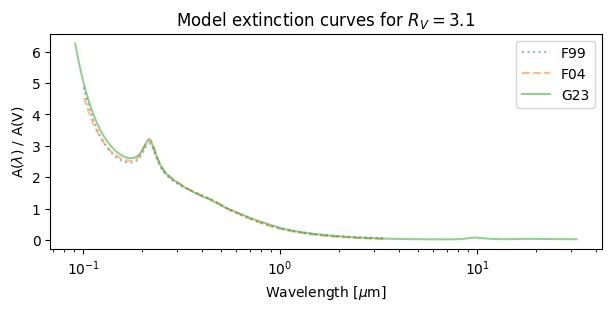

Using the G23 extinction model covers the range from 0.0912 um to 32.0 um.


In [5]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3), constrained_layout=True)
for (_mod, _ls) in [(F99, ":"), (F04, "--"), (G23, "-")]:
    _lambda = (1 / np.logspace(*np.log10(_mod.x_range), num=1000)) * u.um
    ax.plot(_lambda, _mod(Rv=3.1)(_lambda), ls=_ls, alpha=0.5, label=f"{_mod.name}")
ax.set(title=f"Model extinction curves for $R_V=3.1$", xscale="log",
       xlabel=r"Wavelength [$\mu$m]", ylabel=r"A($\lambda$) / A(V)")
ax.legend(loc="best")
plt.show(fig)
plt.close(fig)

# The G23 (Gordon et al., 2023) Milky Way R(V) filter gives us the broadest coverage
ext_model = G23(Rv=3.1)
ext_wl_range = np.reciprocal(ext_model.x_range) * u.um # x_range has implicit units of 1/micron
print(f"Using the {ext_model.__class__.__name__} extinction model covers the range from",
      f"{min(ext_wl_range)} to {max(ext_wl_range)}.")

### Select our target and get its known information

In [6]:
default_target = "CM Dra"
targets_config_file = Path.cwd() / "config" / "fitting-a-sed-targets.json"
with open(targets_config_file, mode="r", encoding="utf8") as f:
    full_dict = json.load(f)
targets_cfg = { k: full_dict[k] for k in full_dict if full_dict[k].get("enabled", True) }

max_teff = max(ne_teff_range).value
options = [
    (f"{t}" + (" *" if c.get("exclude", False) else "") + (" [too hot!]" if min(c["TeffA"], c["TeffB"]) > max_teff else ""), t)
        for t, c in targets_cfg.items()
]

target_selection = Dropdown(options=options, value=default_target, description="Targets:")
display(target_selection)

Dropdown(description='Targets:', index=31, options=(('V436 Per [too hot!]', 'V436 Per'), ('V539 Ara [too hot!]…

In [7]:
target = target_selection.value
target_config = targets_cfg[target]
search_term = target_config.get("search_term", target)
k, k_err = target_config.get("k"), target_config.get("k_err", 0)

# We need the coordinates and approximate distance for extinction lookups
simbad = Simbad()
simbad.add_votable_fields("parallax")
if _tbl := simbad.query_object(search_term):
    target_coords = SkyCoord(ra=_tbl["ra"][0] * _tbl["ra"].unit,
                             dec=_tbl["dec"][0] * _tbl["dec"].unit,
                             distance=1000 / _tbl["plx_value"][0] * u.pc)
    print(f"{target} SkyCoords are {target_coords}")

CM Dra SkyCoords are <SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    (248.58470944, 57.1623247, 14.86157925)>


### Get the SED data for the target
- apply default uncertainties to those measurements with none
- exclude measurements outside the range of our extinction model
- exclude outliers

In [8]:
# Read in the SED for this target
sed = get_sed_for_target(target, search_term, radius=0.1)
print(f"Retrieved {len(sed)} SED observation(s) for {target}")

# Filter SED to those covered by our models and also remove any outliers
model_mask = (sed["sed_wl"] >= min(ext_wl_range)) & (sed["sed_wl"] <= max(ext_wl_range)) \
            & (sed["sed_wl"] >= min(ne_wl_range)) & (sed["sed_wl"] <= max(ne_wl_range))

out_mask = sed["sed_filter"] == "HIP:hp"    # These tend to give outliers at ~0.402 um
if "CW Eri" in target or "V788 Cen" in target:
    out_mask |= sed["sed_filter"] == "Cousins:I"
if "CM Dra" in target:
    out_mask |= sed["sed_filter"] == "WISE:W4"
if "ZZ Boo" in target:
    out_mask |= sed["sed_filter"] == "PAN-STARRS/PS1:y"

# De-duplicate the SED. Measurements often appear multiple times in these data, and to counter
# this we only retain the first instance of each unique combination of filter/flux/eflux value.
sed = sed[model_mask & ~out_mask].group_by(keys=["sed_filter", "sed_flux", "sed_eflux"])
sed = sed[sed.groups.indices[:-1]]
sed.sort(["sed_wl"])
print(f"{len(sed)} unique SED observation(s) retained after filtering and de-duplication")

Retrieved 28 SED observation(s) for CM Dra
16 unique SED observation(s) retained after filtering and de-duplication


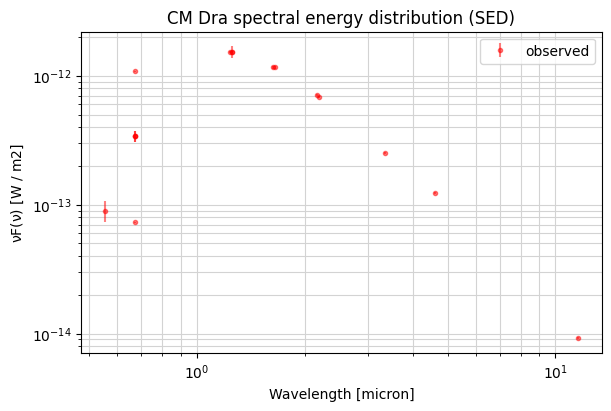

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)
sed_vfv, sed_evfv = calculate_vfv(sed)
ax.errorbar(sed["sed_wl"], sed_vfv, sed_evfv, fmt=".r", alpha=0.5, label="observed")
ax.set(title=f"{target} spectral energy distribution (SED)",
       xscale="log", xlabel=f"Wavelength [{sed['sed_wl'].unit}]",
       yscale="log", ylabel=f"${{\\rm \\nu F(\\nu)}}$ [{sed_vfv.unit}]")
ax.grid(True, which="both", axis="both", color="lightgray")
ax.legend(loc="best")
plt.show(fig)
plt.close(fig)

### De-redden the SED

In [10]:
for val, flags in extinction.get_extinction(target_coords):
    if val and not np.isnan(val) and flags.get("converged", False):
        print(f"Found extinction with {flags['source']}: {flags.get('type', '')} = {val:.6f}")
        if flags.get("type", "") == "B(B-V)":
            sed["sed_der_flux"] = sed["sed_flux"] / ext_model.extinguish(sed["sed_wl"].to(u.um), Ebv=val)
        else:
            sed["sed_der_flux"] = sed["sed_flux"] / ext_model.extinguish(sed["sed_wl"].to(u.um), Av=val)
        break

if "sed_der_flux" in sed.colnames:
    der_lab = "dereddened"
else:
    sed["sed_der_flux"] = sed["sed_flux"]
    der_lab = "not dereddened"

Found extinction with get_gontcharov_ebv: E(B-V) = 0.015330


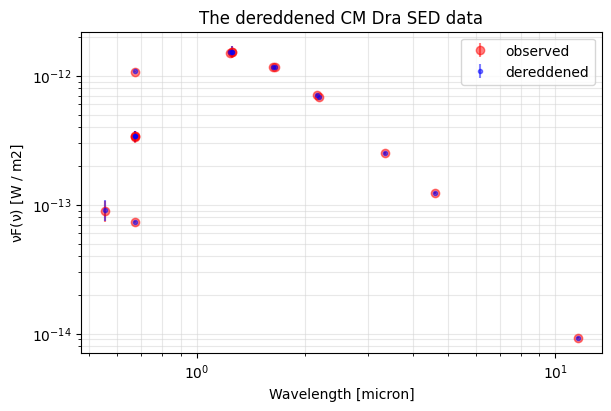

In [11]:
# Create a dereddened vF(v) column for plotting
sed_der_vfv, sed_der_evfv = calculate_vfv(sed, flux_colname="sed_der_flux")
fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)
ax.errorbar(sed["sed_wl"], sed_vfv, sed_evfv, fmt="or", alpha=0.5, label="observed")
ax.errorbar(sed["sed_wl"], sed_der_vfv, sed_der_evfv, fmt=".b", alpha=0.5, label=der_lab)
ax.set(title=f"The dereddened {target} SED data",
       xscale="log", xlabel=f"Wavelength [{sed['sed_wl'].unit}]",
       yscale="log", ylabel=f"${{\\rm \\nu F(\\nu)}}$ [{sed_der_vfv.unit}]")
ax.grid(True, which="both", axis="both", alpha=0.5, color="lightgray")
ax.legend(loc="best")
plt.show(fig)
plt.close(fig)

### Run the MCMC Fit

#### The MCMC functions
- `lnlike` is the _likelihood function_ which compares the model spectra with the observed data.
Its behaviour is fixed so this function is part of the `mcmc_sed` module
- `lnprior` contains any _prior knowledge_ we have about the parameters from elsewhere __and is defined here__
  - in this case there are restrictions on stellar age/phase and a known ratio of radii from LC fitting
  - must returns a blob containing the two stars' $T_{\rm eff}$ and $\log{g}$ values for masses and age being evaluated
  for passing on to the corresponding model function
- `lnprob` combines the two into a probability density. Again the behaviour is fixed so this
function is part of the `mcmc_sed` module

In [12]:
MIN_MASS, MAX_MASS = 0.1, 270.      # realistic MIST mass range
MIN_PHASE, MAX_PHASE = Phase.MS, Phase.MS
mist_ages = mist_isos.list_ages(feh=0, min_phase=MIN_PHASE, max_phase=MAX_PHASE)
MIN_AGE, MAX_AGE = min(mist_ages), max(mist_ages)
MIN_TEFF, MAX_TEFF = ne_teff_range.value
MIN_LOGG, MAX_LOGG = ne_logg_range.value
MIST_PRIOR_PARAMS = ["Teff", "log_g", "R"]

# Target specific priors
k = target_config["k"]
k_flex = max(k * 0.05, target_config.get("k_err", k * 0.1))
print(f"Priors from fitting: k={k:f} +/- flex of {k_flex:f}")

def ln_prior(MA: float, MB: float, age: float):
    """
    The MCMC log prior function which evaluates the properties of the stars defined by
    the current masses and age against known prior constraints.

    Note: the MCMC walkers are exploring stellar masses and age (theta), which we use to find the
    corresponding effective temp, logg and radius for evaluating priors & to generate model spectra.
    """
    # pylint: disable=too-many-locals
    TeffA, TeffB, loggA, loggB = None, None, None, None
    retval = -np.inf # failure

    # Basic validation of priors; lookup won't work if these are out of range of MIST values
    if MIN_MASS <= MA <= MAX_MASS and MIN_MASS <= MB <= MAX_MASS and MIN_AGE <= age <= MAX_AGE:
        try:
            # Get the stellar params to evaluate, plus the Teffs/logg are req'd to generate SEDs
            TeffA, loggA, RA = mist_isos.stellar_params_for_mass(0, age, MA, MIST_PRIOR_PARAMS, MIN_PHASE, MAX_PHASE)
            TeffB, loggB, RB = mist_isos.stellar_params_for_mass(0, age, MB, MIST_PRIOR_PARAMS, MIN_PHASE, MAX_PHASE)

            # Evaluate against priors; in the case of k (ratio of radii) prior is specific to target
            if np.abs((RB / RA) - k) <= k_flex \
                and min(TeffA, TeffB) >= MIN_TEFF and max(TeffA, TeffB) <= MAX_TEFF \
                and min(loggA, loggB) >= MIN_LOGG and max(loggA, loggB) <= MAX_LOGG:
                retval = 0 # params conform to the priors
        except ValueError: # If lookup fails with no match
            pass
    # Return whether the priors are happy (0) and also the revised theta for use by model_func
    return retval, (TeffA, TeffB, loggA, loggB)

# This is passed to EnsembleSampler to define the format of the set of blobs returned from the calls
# to ln_prior() once the ensemble has completed. With this get_blobs() returns a structured array.
blobs_dtype = [("TeffA", float), ("TeffB", float), ("loggA", float), ("loggB", float)]

Priors from fitting: k=0.945000 +/- flex of 0.047250


#### Prepare and run the MCMC

In [13]:
# Mimic basic pre-processing which gives some insight into the nature of the target
# Starting position for the search - round known masses to nearest 0.5 M_sun
init_sigma = 0.1
init_MA = max(MIN_MASS + init_sigma, round(target_config["MA"] * 2) / 2)
init_MB = max(MIN_MASS + init_sigma, round(target_config["MB"] * 2) / 2)
init_age = 9.0 if min(init_MA, init_MB) < 2.0 else 8.0
print(f"MCMC init pos: MA = {init_MA:.6f} & MB = {init_MB:.6f} [M_sun], log(age) = {init_age} [dex(yr)]")

MCMC init pos: MA = 0.200000 & MB = 0.200000 [M_sun], log(age) = 9.0 [dex(yr)]


In [14]:
nwalkers = 100
niters = 100000

rng = np.random.default_rng(42)
initial = np.array([init_MA, init_MB, init_age])
ndim = len(initial)
p0 = [initial + rng.normal(0, init_sigma, ndim) for _ in range(nwalkers)] # wants a list of ndarrays

# Fitting will be based on a normalized copy of the dereddened fluxes
sed["sed_norm_flux"], sed["sed_norm_eflux"] = min_max_normalize(sed["sed_der_flux"].value,
                                                                sed["sed_eflux"].value)

# These the functions for generating synthetic spectra and combining them into a model
if max(init_MA, init_MB) < 4.0:
    spec_func = newera_spectrum
else:
    spec_func = lambda x, Teff, _: blackbody_flux(x, Teff)

def model_func(x, Teff1, Teff2, logg1, logg2):
    return min_max_normalize(np.add(spec_func(x, Teff1, logg1), spec_func(x, Teff2, logg2)))

# These are the "fixed" kwargs which will be sent to the MCMC ln_prob function
kwargs = {
    "x": sed["sed_freq"].value,
    "y": sed["sed_norm_flux"].value,
    "y_err": sed["sed_norm_eflux"].value,
    "ln_prior_func": ln_prior,
    "model_func": model_func
}

In [15]:
with warnings.catch_warnings(category=RuntimeWarning):
    warnings.filterwarnings("ignore") #, message="(?:.*)invalid value encountered in scalar subtract")
    with Pool(processes=None) as pool:
        print(f"Running MCMC for {niters:,} iterations with {nwalkers} walkers.")
        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_fn=ln_prob, kwargs=kwargs,
                                        blobs_dtype=blobs_dtype, pool=pool)
        state = sampler.run_mcmc(p0, niters, progress=True)

Running MCMC for 100,000 iterations with 100 walkers.


100%|██████████| 100000/100000 [14:05<00:00, 118.30it/s]


In [16]:
accept_frac = np.mean(sampler.acceptance_fraction)
print(f"Mean Acceptance fraction: {accept_frac:.6f}")

try:
    # autocorrelation time; steps to effectively "forget" start position
    tau = sampler.get_autocorr_time(c=1)
    print(f"Autocorrelation steps:   ", ", ".join(f"{t:.3f}" for t in tau))
except AutocorrError as err:
    print(f"\033[93m\033[1m{err}\033[0m")
    tau = err.tau

/home/steveo/projects/main/platodebcat/.platodebcat/lib/python3.11/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in divide
  acf /= acf[0]


Mean Acceptance fraction: 0.287160
Autocorrelation steps:    nan, nan, nan


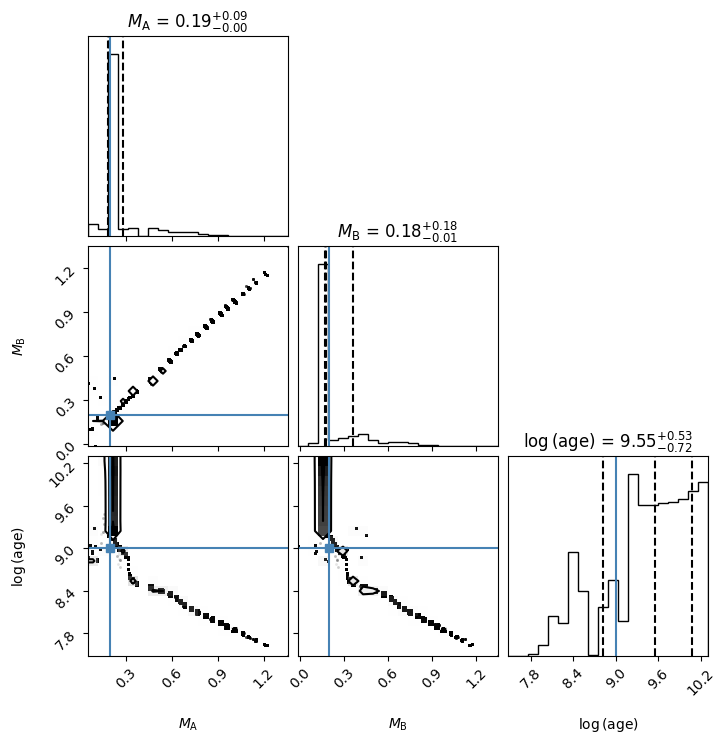

In [17]:
warm_discard = int(np.mean(np.nan_to_num(tau, copy=True, nan=1000))) * 2
thin = max(1, int(1 / (1-max(accept_frac, 0.1))))

# thin; every nth step from the chain
samples = sampler.get_chain(discard=warm_discard, thin=thin, flat=True)
fig = corner.corner(samples, show_titles=True, plot_datapoints=True, quantiles=[0.16, 0.5, 0.84],
                    labels=[r"$M_{\rm A}$", r"$M_{\rm B}$", r"$\log{({\rm age})}$"],
                    truths=[init_MA, init_MB, init_age])
plt.show(fig)
plt.close(fig)

In [18]:
# Gets the median fitted values (currently M1, M2 and log(age))
fitted_vals = np.median(samples, axis=0)
fitted_high = np.quantile(samples, 0.84, axis=0) - fitted_vals
fitted_low = fitted_vals - np.quantile(samples, 0.16, axis=0)

print(f"Best fit parameters for {target} from {niters:,} MCMC iterations")
for ix, (k, unit) in enumerate([("MA", u.solMass), ("MB", u.solMass), ("age", u.dex(u.yr))]):
    print(f"{k:>9s} = {fitted_vals[ix]:.3f} +/- {fitted_high[ix]:.3f}/{fitted_low[ix]:.3f} {unit}",
          f"(known value {target_config.get(k, np.NaN)} +/- {target_config.get(k+'_err', '')})")

Best fit parameters for CM Dra from 100,000 MCMC iterations
       MA = 0.190 +/- 0.090/0.004 solMass (known value 0.231 +/- 0.0009)
       MB = 0.178 +/- 0.181/0.006 solMass (known value 0.2141 +/- 0.001)
      age = 9.549 +/- 0.527/0.725 dex(yr) (known value 9.9 +/- )


Plotting Star A where Teff = 3210 K and logg = 5.065
PLotting Star B where Teff = 3185 K and logg = 5.081


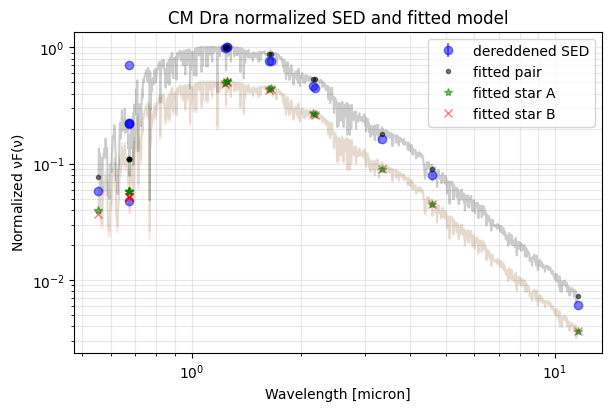

In [19]:
# Need to get the effective temperatures & logg for these masses/age combinations
MA, MB, log_age = fitted_vals
teffA, loggA = mist_isos.stellar_params_for_mass(0, log_age, MA, ["Teff", "log_g"], MIN_PHASE, MAX_PHASE)
teffB, loggB = mist_isos.stellar_params_for_mass(0, log_age, MB, ["Teff", "log_g"], MIN_PHASE, MAX_PHASE)

print(f"Plotting Star A where Teff = {teffA:.0f} K and logg = {loggA:.3f}")
print(f"PLotting Star B where Teff = {teffB:.0f} K and logg = {loggB:.3f}")

# Generate a model SED from the fitted values for plotting
sed_freq = sed["sed_freq"].value
mod_star_vfv = np.array([spec_func(sed_freq, teffA, loggA), spec_func(sed_freq, teffB, loggB)]) * sed_freq
mod_comb_vfv = np.add(*mod_star_vfv)
mod_scale = mod_comb_vfv.max() - mod_comb_vfv.min()

# Generate equivalent model SED over many points to plot "continuous" models
cont_lambda = np.logspace(np.log10(sed["sed_wl"].min()), np.log10(sed["sed_wl"].max()), 1000)
cont_freq = c*1e6 / cont_lambda
cont_star_vfv = np.array([spec_func(cont_freq, teffA, loggA), spec_func(cont_freq, teffB, loggB)]) * cont_freq
cont_comb_vfv = np.add(*cont_star_vfv)

# Get the dereddened observed SED data
sed_scale = sed_vfv.max() - sed_vfv.min()

# Plot the fitted model against the derredened SED + show each star's contribution
fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)
for (lam,           flux,              eflux,           scale,      fmt,    alpha,  z,      label) in [
    (sed["sed_wl"], sed_vfv,           sed_evfv,        sed_scale,  "ob",   0.5,    50,     "dereddened SED"),
    (sed["sed_wl"], mod_comb_vfv,      None,            mod_scale,  ".k",   0.5,    90,     "fitted pair"),
    (sed["sed_wl"], mod_star_vfv[0],   None,            mod_scale,  "*g",   0.5,    80,     "fitted star A"),
    (sed["sed_wl"], mod_star_vfv[1],   None,            mod_scale,  "xr",   0.5,    70,     "fitted star B"),
    (cont_lambda,   cont_comb_vfv,     None,            mod_scale,  "-k",   0.2,    20,     None),
    (cont_lambda,   cont_star_vfv[0],  None,            mod_scale,  "-g",   0.1,    15,     None),
    (cont_lambda,   cont_star_vfv[1],  None,            mod_scale,  "-r",   0.1,    10,     None),
]:
    # Rather than (flux-min(flux))/norm_scale we plot flux/norm_scale so that we don't loose the lowest value to zero
    ax.errorbar(lam, flux/scale, eflux, fmt=fmt, alpha=alpha, zorder=z, label=label)
ax.set(title=f"{target} normalized SED and fitted model", xscale="log", yscale="log",
       xlabel=f"Wavelength [{sed['sed_wl'].unit}]", ylabel=r"Normalized ${\rm \nu F(\nu)}$")
ax.grid(True, which="both", axis="both", color="lightgray", alpha=0.5, zorder=0)
ax.legend(loc="best")
plt.show(fig)
# plt.close(fig)